In [9]:
import itertools
import csv
import pandas as pd
from datetime import datetime, timedelta
import json

import openeo
from openeo.extra.job_management import MultiBackendJobManager
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


BASE_SPATIAL_LOC = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
BASE_TEMPORAL_DATE = '2020-01-01'


def create_spatial_extent(base_extent=BASE_SPATIAL_LOC, size=100):
    return {
        "west": base_extent["west"],
        "south": base_extent["south"],
        "east": base_extent["west"] + size,
        "north": base_extent["south"] + size,
        "crs": base_extent["crs"],
        "srs": base_extent["srs"]
    }

def calculate_temporal_extent(start_date= BASE_TEMPORAL_DATE, months=1):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + timedelta(days=30 * months)
    return [start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')]


def prepare_jobs(temporal_range, spatial_range, process_graph_path, repetition = 1, max_cost = 100):
    """
    Prepares a DataFrame containing the jobs used for benchmarking.

    This function generates all possible combinations of spatial sizes and temporal extents, 
    and repeats this process for a specified number of iterations. For each combination, 
    it constructs a job dictionary containing the spatial range, spatial extent, temporal 
    range, temporal extent, and relevant process graph information. The resulting jobs 
    are compiled into a DataFrame.

    Parameters:
        temporal_extents (list): A list of temporal extents (e.g., months) to be used in the jobs.
        spatial_sizes (list): A list of spatial sizes to be used in the jobs.
        process_graph_path (str): The file path to the process graph JSON file.
        repetition (int, optional): The number of times to repeat the generation of all 
                                    combinations of spatial sizes and temporal extents. 
                                    Defaults to 1.

    Returns:
        pd.DataFrame: A DataFrame where each row represents a job with the specified 
                      spatial and temporal extents, and associated process graph information.
    """
    
    jobs = []

    if not isinstance(temporal_range, (list, tuple)):
        temporal_range = [temporal_range]
    if not isinstance(spatial_range, (list, tuple)):
        spatial_range = [spatial_range]

    with open(process_graph_path) as f:
        pg = json.load(f)

    for ii in range(repetition):
        combinations = itertools.product(spatial_range, temporal_range)
        for size, months in combinations:
            jobs.append({
                "spatial_range": size,
                "spatial_extent": create_spatial_extent(size=size),
                "temporal_range": months,
                "temporal_extent": calculate_temporal_extent(months=months),
                "process_graph_path": process_graph_path,
                "process_graph_id": pg["id"],
                "max_cost": max_cost,
            })

    return pd.DataFrame(jobs)


def start_job(row: pd.Series, connection, **kwargs)-> openeo.BatchJob:
    """
    Callback function for the openEO MultiBackendJobManager to start a new job.
    :param data: Dictionary containing the general information for launching the job
    :return: OpenEO Batch Job
    """

    process_graph_path = row["process_graph_path"]
    spatial_extent = row["spatial_extent"]
    temporal_extent = row["temporal_extent"]
    

    cube = connection.datacube_from_json(
        process_graph_path,
        parameters={"spatial_extent": spatial_extent, "temporal_extent": temporal_extent}
    )

    
    return cube.create_job(
        title=f'Process Graph  - Benchmark',
        format="netcdf",
        budget = row["max_cost"]
    )

# Define the get_job_cost_info function
def get_job_cost_info(connection, job_id):
    """Retrieve job cost information from the connection."""
    try:
        job = connection.job(job_id).describe_job()
        return float(job["costs"])
    except:
        return "costs"
    
def update_job_cost_info(df, connection):
    df['job_cost'] = df.apply(lambda row: get_job_cost_info(connection, row['id']), axis=1)
    return df

# Load process graph
def load_process_graph(path):
    with open(path) as f:
        return json.load(f)

# Generate output file name
def generate_output_file_name(prefix, pg_id):
    time_stamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    return f"{prefix}_{pg_id}_{time_stamp}.csv"

In [11]:
manager = MultiBackendJobManager()
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
manager.add_backend("cdse", connection=connection, parallel_jobs=10)

#% Define the sizes in meters for spatial extents
spatial_range = [100, 1000, 10000, 100000]  # +meter
temporal_range = [1, 6, 12]
process_graph_path = 'NDWI.json'

jobs_df = prepare_jobs(temporal_range, spatial_range, process_graph_path, repetition = 3, max_cost = 10)
pg = load_process_graph(process_graph_path)
output_file = generate_output_file_name("UDP_cost_profile", pg["id"])

manager.run_jobs(df=jobs_df,start_job = start_job,output_file=output_file)
output_file = update_job_cost_info(output_file, connection)

Authenticated using refresh token.


In [8]:
# Add cost information

import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv(output_file)



# Apply the get_job_cost_info function to each row
df['job_cost'] = df.apply(lambda row: get_job_cost_info(connection, row['id']), axis=1)

# Save the updated DataFrame back to a CSV file if needed
df.to_csv(output_file, index=False)


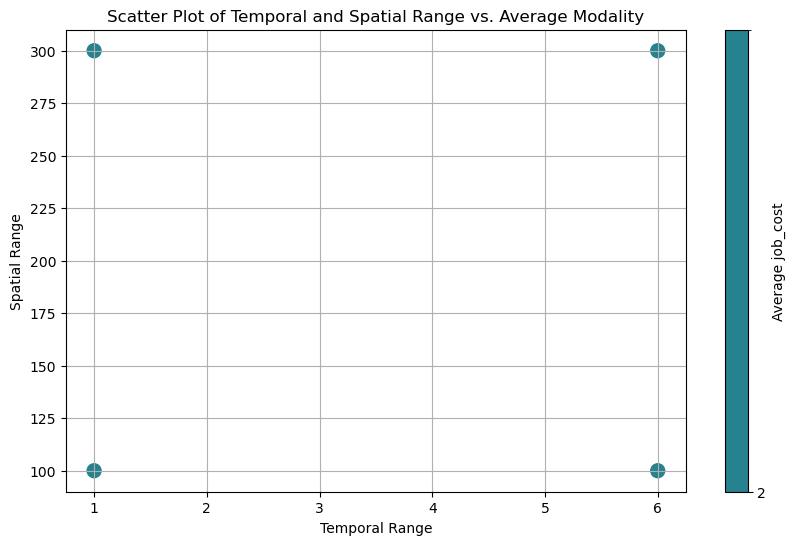

In [26]:
# Load the DataFrame
from matplotlib.colors import BoundaryNorm, ListedColormap

df = pd.read_csv(output_file)

# Select the output modality (e.g., 'job_cost')
output_modality = 'job_cost'

# Find all unique combinations of spatial and temporal range
unique_combinations = df[['spatial_range', 'temporal_range']].drop_duplicates()

# Calculate the average of the output modality for each unique combination
average_modality = df.groupby(['spatial_range', 'temporal_range'])[output_modality].mean().reset_index()

# Define the discrete colormap
cmap = plt.get_cmap('viridis', 10)  # 10 discrete colors
norm = BoundaryNorm(boundaries=range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 2), ncolors=cmap.N, clip=True)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(average_modality['temporal_range'], average_modality['spatial_range'], c=average_modality[output_modality], cmap=cmap, norm=norm, s=100)
cbar = plt.colorbar(sc, ticks=range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 1))
cbar.set_label(f'Average {output_modality}')
cbar.set_ticks(range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 1))
plt.xlabel('Temporal Range')
plt.ylabel('Spatial Range')
plt.title('Scatter Plot of Temporal and Spatial Range vs. Average Modality')
plt.grid(True)